In [1]:
# importing relevant modules
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot   as plt
import librosa
import numpy as np
import json
from statistics import stdev

from pandas                import read_csv, to_datetime
from numpy                 import reshape, array
from datetime              import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers          import Dense, Dropout, LSTM, Input, TimeDistributed
from keras.models          import Model
from keras_tqdm            import TQDMNotebookCallback
from IPython.display       import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.callbacks       import EarlyStopping
from keras.layers import Conv2DTranspose

%matplotlib inline


Using TensorFlow backend.


In [2]:
samples_per_chunk = 300
num_chunks_per_slice = 65
num_chunks_per_beat = 8
song_filename = 'song.ogg'
beatmap_filename = 'Expert.json'

In [3]:
def loadbeatmap(beatmap, num_beats, num_chunks_per_beat=8):
    if beatmap[len(beatmap)-5:len(beatmap)] != ".json":
        print("Beatmap file " + audio + " is not of type .json")
        return -1
    
    with open(beatmap) as f:
        data = json.load(f)
  
    notes = "_notes"
    time = "_time"
    line_index = "_lineIndex" #column number
    line_layer = "_lineLayer" #row number
    note_color = "_type" #0 is one color and 1 is the other
    cut_direction = "_cutDirection"#9 cut directions

    dim_0 = num_beats * num_chunks_per_beat
    
    # number of rows and columns in the playfield
    # number of cells in the playfield (each cell can hold at most 1 note)
    playfield_rows = 3
    playfield_cols = 4
    playfield_cell_count = playfield_rows * playfield_cols
    
    # number of colors (2): red, blue (order unknown)
    # number of directions notes can face (9): 
    # up, down, left, right, up-left, up-right, down-left, down-right, dot (order unknown)
    note_color_count = 2
    note_direction_count = 9
    
    # dimensions for a 'one-hot' representation of a single time unit (chunk)
    dim_1 = playfield_rows
    dim_2 = playfield_cols
    dim_3 = (note_color_count + 1) + (note_direction_count + 1)
    
    # initialize matrix to zeros, then set the "no note" bit for each block at each timestep to 1
    outMatrix = np.zeros(shape=(dim_0, dim_1, dim_2, dim_3))
    outMatrix[:,:,:,0] = 1
    outMatrix[:,:,:,3] = 1
    

    # for every note in the beatmap, set the color and direction bits for the proper cell to 1
    for n in range(len(data[notes])):
        entry = int(np.round(data[notes][n][time]*num_chunks_per_beat)) #convert time to row index by rounding to nearest 1/8 beat
        if data[notes][n][note_color] < 2:
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][note_color]+1] = 1
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [0] = 0
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][cut_direction]+4] = 1
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [3] = 0

    return outMatrix

In [4]:
def mean_center(x): 
    return (x - np.apply_along_axis(np.mean, 0, x) )

In [5]:
def loadsong(audio, samples_per_chunk=300, num_chunks_per_slice=65, num_chunks_per_beat=8, verbose=0):
    if audio[len(audio)-4:len(audio)] != ".ogg":
        print("Audio file " + audio + " is not of type .ogg")
        return -1
    
    y, sr = librosa.load(audio)
    
    song_length = librosa.get_duration(y=y,sr=sr) / 60.0
    tempo = int(np.round(librosa.beat.tempo(y, sr=sr)))
    new_sample_rate = (tempo/200)*8000
    
    y = librosa.resample(y, sr, new_sample_rate)
    
    number_of_beats = int(tempo * song_length)
    
    return y[0:(len(y)//(samples_per_chunk*num_chunks_per_beat)*(samples_per_chunk*num_chunks_per_beat))], \
        new_sample_rate, number_of_beats, tempo

In [6]:
def prep_song(song, sample_per_chunk = 300):
    song_y = song.reshape(len(song)//300,300)
    song_fft = np.abs(np.apply_along_axis(np.fft.fft, 1, song_y))[:,0:(int)(samples_per_chunk/2)+1]
    song_fft_mc = np.apply_along_axis(mean_center, 0, song_fft)
    return song_fft_mc

In [7]:
def append_song(init_song, init_beatmap, song_filepath, beatmap_filepath, num_chunks_per_beat = 8, num_beats_per_sequence = 32):
    num_chunks_per_sequence = num_chunks_per_beat * num_beats_per_sequence
    
    loaded_song_y, loaded_song_sr, num_beats, tempo = loadsong(song_filepath)
    
    prepped_song = prep_song(loaded_song_y)
    
    loaded_beatmap = loadbeatmap(beatmap_filepath, num_beats)
    
    if init_song == None and init_beatmap == None:
        init_song = []
        init_beatmap = []
        
    for i in range(num_beats*num_chunks_per_beat-num_chunks_per_sequence):
        init_song.append(prepped_song[i:i+num_chunks_per_sequence]) 
    for i in range(num_beats*num_chunks_per_beat-num_chunks_per_sequence):
        init_beatmap.append(loaded_beatmap[i:i+num_chunks_per_sequence]) 
    
    init_song = np.array(init_song)
    init_beatmap = np.array(init_beatmap)
        
    return init_song, init_beatmap, tempo

In [8]:
def data_prep(song_list, beatmap_list):
    X, Y, tempo = append_song(None, None, song_list[0], beatmap_list[0])
    for x, y in zip(song_list[1:], beatmap_list[1:]):
        X, Y, tempo = append_song(X, Y, x, y)
    
    return X, Y, tempo

In [9]:
def softmax_to_max(note_cell):
    output = []
    output.append(np.argmax(note_cell[:3]))
    output.append(np.argmax(note_cell[3:]))
    
    return output

In [10]:
#Thanks to @shouldsee from https://github.com/mpld3/mpld3/issues/434#issuecomment-340255689

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [11]:
def convert_beatmap_array(nn_out, division = 4):
    original_size = nn_out.shape[0]
    sequence_size = nn_out.shape[1]
    target_size = nn_out.shape[1] + nn_out.shape[0]

    slice_start = (sequence_size * (division - 1) // (division * 2))
    slice_end = sequence_size * (division + 1) // (division * 2)
    slice_size = slice_end - slice_start
    
    beatmap = np.zeros(shape=(target_size,3,4,13), dtype = float)
    #first section of the beatmap array
    beatmap[0:slice_end] = nn_out[0, 0:slice_end,:,:,:]
    
    #middle section
    i = slice_size
    while i < original_size:
        beatmap[i+slice_start:i+slice_end] = nn_out[i, slice_start:slice_end,:,:,:]
        i+=slice_size
    
    #final section 
    final_start_index = -(original_size - (i - slice_size))
    print(final_start_index)
    
    beatmap[final_start_index:target_size] = nn_out[original_size-1, final_start_index:sequence_size,:,:,:]
    
    return beatmap

In [12]:
def convert_to_json(original_beatmap, bpm, chunks_per_beat = 8, offset = 0.0, beats_per_bar=16, 
                    note_jump_speed=10, shuffle=0, shuffle_period=0.5, version="1.5.0"):
    
    new_beatmap = {}
    new_beatmap['_version'] = version
    new_beatmap['_beatsPerMinute'] = bpm
    new_beatmap['_beatsPerBar'] = beats_per_bar
    new_beatmap['_noteJumpSpeed'] = note_jump_speed
    new_beatmap['_shuffle'] = shuffle
    new_beatmap['_shufflePeriod'] = shuffle_period
    new_beatmap['_events'] = []
    new_beatmap['_notes'] = []
    new_beatmap['_obstacles'] = []

    new_beatmap['_notes'] = [
        {
            "_time" : (i  / chunks_per_beat) + offset,
            "_lineIndex" : k,
            "_lineLayer" : j,
            "_type" : original_beatmap[i][j][k][0] - 1,
            "_cutDirection" : original_beatmap[i][j][k][1] - 1
        } for i in range(original_beatmap.shape[0])
          for j in range(original_beatmap.shape[1])
          for k in range(original_beatmap.shape[2]) if original_beatmap[i][j][k][0] != 0]
    
    return new_beatmap

In [13]:
def export_beatmap(nn_output, tempo, filename = 'beatmap.json', 
                   division = 4, chunks_per_beat = 8, offset = 0.0,
                   beats_per_bar=16, note_jump_speed=10,
                   shuffle=0, shuffle_period=0.5, version="1.5.0"):
    
    resized_map = convert_beatmap_array(nn_output, division)
    converted_map = np.apply_along_axis(softmax_to_max, 3, resized_map)
    json_beatmap = convert_to_json(converted_map, tempo, chunks_per_beat, 
                                   offset, beats_per_bar, note_jump_speed, 
                                   shuffle, shuffle_period, version)

    with open(filename, 'w') as outfile:
        outfile.write(json.dumps(json_beatmap, cls=NumpyEncoder))

In [14]:
X, Y, tempo  = data_prep(["Last_Dance_song.ogg"], ["Last_Dance_Expert.json"]) 

In [15]:
X.shape

(3856, 256, 151)

In [16]:
Y.shape

(3856, 256, 3, 4, 13)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 151)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 32)      24192       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 64, 32)       5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 32, 32)       5152        conv1d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

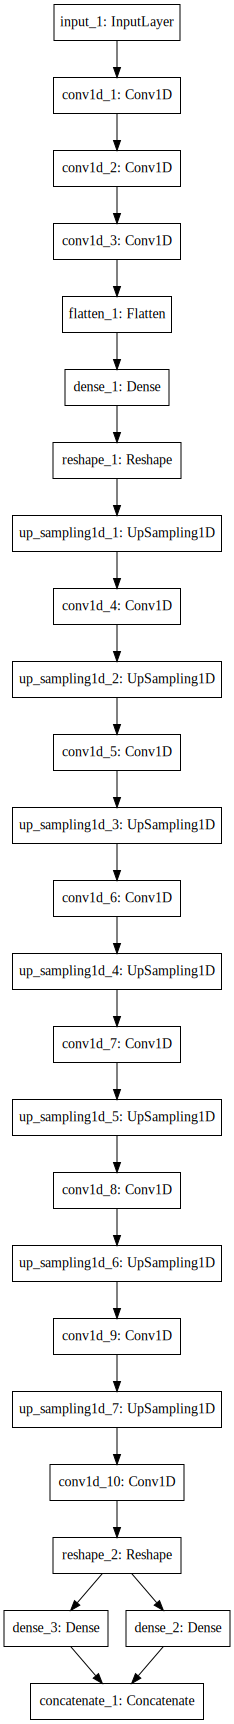

In [17]:
# probably a better model
inputs = keras.layers.Input(shape=(X.shape[1], X.shape[2]))
x = keras.layers.Conv1D(filters=32,
                        kernel_size=5,
                        strides=2,
                        activation='relu',
                        padding='same')(inputs)
x = keras.layers.Conv1D(filters=32,
                        kernel_size=5,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
x = keras.layers.Conv1D(filters=32,
                        kernel_size=5,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense((256 * 3 * 4) // 2**7)(x)
x = keras.layers.Reshape(((256 * 3 * 4) // 2**7, 1))(x) # gives a channel dimension so we can Conv1D

for _ in range(7):
    x = keras.layers.UpSampling1D(2)(x)
    x = keras.layers.Conv1D(filters=13,
                            kernel_size=5,
                            strides=1,
                            activation='relu',
                            padding='same')(x)
    
x = keras.layers.Reshape((256, 3 , 4, 13))(x)
color_output = keras.layers.Dense(3, activation='softmax')(x)
direc_output = keras.layers.Dense(10, activation='softmax')(x)
outputs = keras.layers.concatenate([direc_output, color_output])

cnn_model = keras.Model(inputs, outputs)
cnn_model.compile(loss=keras.losses.categorical_crossentropy,
                     optimizer=keras.optimizers.Adam(lr=1e-3),
                     metrics=['accuracy'])
cnn_model.summary()
SVG(model_to_dot(cnn_model).create(prog='dot',format='svg'))

In [18]:
batch_size = 2**9
epochs = 50
cnn_history = cnn_model.fit(X, Y,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=0,
                   callbacks=[TQDMNotebookCallback()],
                   validation_split = 0.2)
print('Accuracy:', cnn_model.evaluate(X,Y)[1]*100.0,'%')


3856/3856 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 682us/step
Accuracy: 49.043301341444625 %


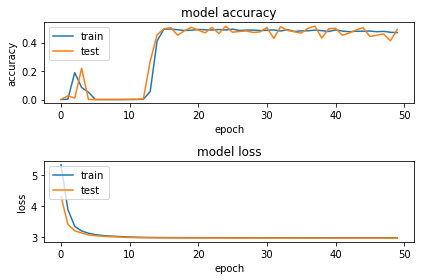

In [19]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 151)     0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 156, 32)      488064      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 156, 20)      4240        conv1d_11[0][0]                  
__________________________________________________________________________________________________
up_sampling1d_8 (UpSampling1D)  (None, 312, 20)      0           lstm_1[0][0]                     
__________________________________________________________________________________________________
conv1d_12 

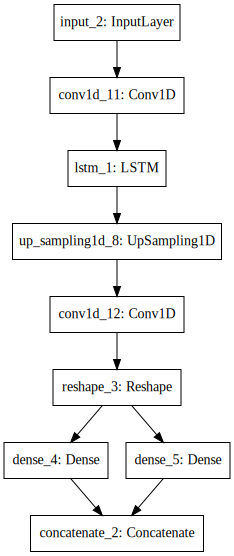

In [20]:
#CNN + LSTM Model

lstm_size = 20
input_layer = keras.layers.Input(shape=(X.shape[1], X.shape[2]))
cnn_layer = keras.layers.Conv1D(32, kernel_size=((X.shape[1] - 155)), 
                                activation='relu',
                                input_shape=[X.shape[1], X.shape[2]])
lstm_layer = keras.layers.LSTM(lstm_size, return_sequences = True)
dense_direction = keras.layers.Dense(10, activation ='softmax')
dense_color = keras.layers.Dense(3, activation = 'softmax')
deconv_layer = keras.layers.Conv1D(156, kernel_size=((X.shape[1] - 199)), activation='relu')
reshaper = keras.layers.Reshape((256, 3, 4, 13))
cnn_output = cnn_layer(input_layer)
lstm_output = lstm_layer(cnn_output)

lstm_output = keras.layers.UpSampling1D(2)(lstm_output)
deconv_output = deconv_layer(lstm_output)
reshape_output = reshaper(deconv_output)
direction_output = dense_direction(reshape_output)
color_output = dense_color(reshape_output)
dense_inputs = [direction_output, color_output]
final_output = keras.layers.concatenate(dense_inputs, axis = -1)

cnn_lstm_model = keras.Model(input_layer, final_output)
cnn_lstm_model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
cnn_lstm_model.summary()
SVG(model_to_dot(cnn_lstm_model).create(prog='dot',format='svg'))


In [21]:
batch_size = 2**7
epochs = 50
history = cnn_lstm_model.fit(X, Y,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=0,
                   callbacks=[TQDMNotebookCallback()],
                   validation_split = 0.2)
print('Accuracy:', cnn_lstm_model.evaluate(X,Y)[1]*100.0,'%')


3856/3856 [==============================] - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA: 

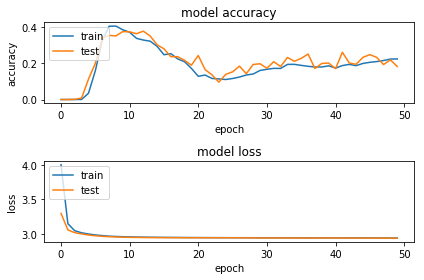

In [22]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()


In [29]:
np.average((cnn_history.history['val_acc']))

0.35519118850731657

In [30]:
predict_output = cnn_model.predict(X)

In [31]:
predict_output

array([[[[[4.85093594e-01, 1.63191240e-02, 8.00716691e-03, ...,
           3.28264952e-01, 5.47010720e-01, 1.24724314e-01],
          [5.30814111e-01, 6.57504471e-03, 4.15508682e-03, ...,
           3.43050152e-01, 5.42440057e-01, 1.14509769e-01],
          [5.15485525e-01, 1.81778660e-03, 2.45605223e-03, ...,
           5.13858676e-01, 3.71550590e-01, 1.14590704e-01],
          [4.69787836e-01, 1.35539728e-03, 1.24684779e-03, ...,
           3.83177608e-01, 5.05458891e-01, 1.11363538e-01]],

         [[5.04282534e-01, 1.21354114e-03, 7.96037726e-04, ...,
           2.92949080e-01, 6.00437343e-01, 1.06613576e-01],
          [4.48216349e-01, 8.18664557e-04, 6.85430365e-04, ...,
           2.47523487e-01, 6.24500871e-01, 1.27975643e-01],
          [5.29806018e-01, 8.95829638e-04, 9.29108879e-04, ...,
           3.83005410e-01, 4.76537943e-01, 1.40456617e-01],
          [5.08850694e-01, 8.34846112e-04, 9.66843741e-04, ...,
           3.51679981e-01, 5.07787406e-01, 1.40532553e-01]],

    

In [32]:
Y

array([[[[[1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.]],

         [[1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.]],

         [[1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.]]],


        [[[1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.]],

         [[1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.]],

         [[1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.]]],




In [33]:
export_beatmap(predict_output, tempo, filename = 'gen.json')


-16
